In [1]:
#import libraries
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
!pip install torchsummary

In [2]:
#Define the model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # n_in = 28, n_out = 12, r_in = 1, r_out = 6, j_in = 1, j_out = 2
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 16, 3),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 16, 3),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.025),
        )

        # n_in = 12, n_out = 4, r_in = 6, r_out = 16, j_in = 2, j_out = 4
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 24, 3),
            nn.ReLU(),
            nn.BatchNorm2d(24),
            nn.Conv2d(24, 32, 3),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.025),
            nn.Conv2d(32, 16, 1)
        )

        # n_in = 4, n_out = 4, r_in = 16, r_out = 24, j_in = 4, j_out = 4
        self.conv3 = nn.Sequential(
            nn.Conv2d(16, 32, 3,padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
        )

        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)  # GAP reduces spatial dimensions to 1x1

        # define fully connected layer
        self.fc = nn.Linear(32, 10)



    def forward(self, x):
      x = self.conv1(x)
      x = self.conv2(x)
      x = self.conv3(x)
      x = self.global_avg_pool(x)     # Apply GAP
      x = x.view(x.size(0),-1)
      x = self.fc(x)                  # Get the output from the fully connected layer
      return F.log_softmax(x,dim=1)   # Apply log_softmax activation function for the output layer.


In [3]:
# Get model summary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             160
              ReLU-2           [-1, 16, 26, 26]               0
       BatchNorm2d-3           [-1, 16, 26, 26]              32
            Conv2d-4           [-1, 16, 24, 24]           2,320
              ReLU-5           [-1, 16, 24, 24]               0
       BatchNorm2d-6           [-1, 16, 24, 24]              32
         MaxPool2d-7           [-1, 16, 12, 12]               0
           Dropout-8           [-1, 16, 12, 12]               0
            Conv2d-9           [-1, 24, 10, 10]           3,480
             ReLU-10           [-1, 24, 10, 10]               0
      BatchNorm2d-11           [-1, 24, 10, 10]              48
           Conv2d-12             [-1, 32, 8, 8]           6,944
             ReLU-13             [-1, 32, 8, 8]               0
      BatchNorm2d-14             [-1, 3

In [4]:

# Train data transformations
train_transforms = transforms.Compose([
    # Randomly apply CenterCrop(22) with a 10% probability
    # Purpose: Introduce variability during training by randomly cropping images.
    transforms.RandomApply([transforms.CenterCrop(22), ], p=0.1),


    # Randomly rotate the image by an angle between -15 and +15 degrees
    # fill = 0 to fill with black pixels as background
    # Purpose: Augment the training data by introducing random rotations.
    transforms.RandomRotation((-15., 15.), fill=0),


    # Resize the image to 28x28 pixels ( by default the extra pixels as black)
    # Purpose: Standardize the image size for model input.(To maintain the consistent size of the images, resize should be done after all cropping/rotation which have the possibility of altering the image size)
    transforms.Resize((28, 28)),

    # Convert the image to a PyTorch tensor
    # Purpose: Prepare the image data for neural network input.
    transforms.ToTensor(),

    # Normalize the pixel values using mean 0.1307 and standard deviation 0.3081
    # Purpose: Normalize pixel values to improve model convergence and performance.
    transforms.Normalize((0.1307,), (0.3081,)),
])

# Test data transformations
test_transforms = transforms.Compose([
    # Convert the image to a PyTorch tensor
    # Purpose: Prepare test data in the same format as training data.
    transforms.ToTensor(),


    # Normalize the pixel values using mean 0.1307 and standard deviation 0.3081
    # Purpose: Normalize pixel values to improve model convergence and performance.
    transforms.Normalize((0.1307,), (0.3081,)),
])


train_data = datasets.MNIST('../data', train=True, download=True, transform=train_transforms)  # download and load the "training" data of MNIST and apply train_transform
test_data = datasets.MNIST('../data', train=False, download=True, transform=test_transforms)   # download and load the "test" data of MNIST and apply test_transform


torch.manual_seed(1)


# Define the batch size for data loading
batch_size = 256

# Create a dictionary of keyword arguments (kwargs) for DataLoader
kwargs = {
    'batch_size': batch_size,   # Set the batch size for each batch of data
    'shuffle': True,            # ensures that the model encounters a diverse mix of data during training, leading to better learning and generalization (during testing, the order of data doesn’t impact the model’s predictions)
    'num_workers': 2,           # Number of worker threads for data loading ( each worker will deal with batchsize/num_workers set of data under a batch) # parallel processing-> reduces overall time
    'pin_memory': True          # Enable pinning memory for faster GPU transfer
}

# Create DataLoader instances for test and train data
# Note: test_data should be loaded for test_loader
test_loader = torch.utils.data.DataLoader(test_data, **kwargs)   # load test data
train_loader = torch.utils.data.DataLoader(train_data, **kwargs) # load train data


100%|██████████| 9912422/9912422 [00:00<00:00, 96507702.48it/s]


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 119817699.13it/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 31816803.90it/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 21477484.52it/s]


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



In [5]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

In [6]:


from tqdm import tqdm  # Import tqdm for progress bars

def GetCorrectPredCount(pPrediction, pLabels):
  # This function computes the number of correct predictions by comparing
  # the predicted labels (with the highest probability) against the true labels.
  return pPrediction.argmax(dim=1).eq(pLabels).sum().item()

def train(model, device, train_loader, optimizer, criterion):
  # Initialize lists to store training losses and accuracies if not already present
  global train_losses
  global train_acc

  model.train()  # Set the model to training mode
  pbar = tqdm(train_loader)  # Wrap the data loader with tqdm for a progress bar

  train_loss = 0  # Initialize total training loss
  correct = 0  # Initialize total number of correct predictions
  processed = 0  # Initialize total number of processed samples

  for batch_idx, (data, target) in enumerate(pbar):
    # Move the batch data and labels to the specified device (GPU)
    data, target = data.to(device), target.to(device)

    optimizer.zero_grad()  # Clear the gradients of all optimized variables

    # Forward pass: compute predicted outputs by passing inputs to the model
    pred = model(data)

    # Compute loss: calculate the batch loss by comparing predicted and true labels
    loss = criterion(pred, target)
    train_loss += loss.item()  # Aggregate the loss

    # Backward pass: compute gradient of the loss with respect to model parameters
    loss.backward()
    optimizer.step()  # Perform a single optimization step (parameter update)

    correct += GetCorrectPredCount(pred, target)  # Update total correct predictions for the batch
    processed += len(data)  # Update total processed samples of batch

    # Update progress bar description with current loss and accuracy
    pbar.set_description(desc=f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

  # Calculate and store the average accuracy and loss for this training epoch of training data
  train_acc.append(100*correct/processed)
  train_losses.append(train_loss/len(train_loader))


def test(model, device, test_loader, criterion):
  # Initialize lists to store test losses and accuracies if not already present
  global test_acc
  global test_losses

  model.eval()  # Set the model to evaluation mode
  test_loss = 0  # Initialize total test loss
  correct = 0  # Initialize total number of correct predictions

  with torch.no_grad():  # Disable gradient calculation
    for batch_idx, (data, target) in enumerate(test_loader):
      # Move the batch data and labels to the specified device (GPU)
      data, target = data.to(device), target.to(device)

      output = model(data)  # Compute output by passing inputs to the model
      test_loss += criterion(output, target).item()  # Sum up batch loss

      correct += GetCorrectPredCount(output, target)  # Update total correct predictions for each batch in test data

  # Calculate and store the average loss and accuracy for this test run
  test_loss /= len(test_loader.dataset)
  test_acc.append(100. * correct / len(test_loader.dataset))
  test_losses.append(test_loss)

  # Print test results
  print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.1f}%)\n'.format(
      test_loss, correct, len(test_loader.dataset),
      100. * correct / len(test_loader.dataset)))


In [7]:

# Initialize the model and move it to the device ( GPU )
model = Net().to(device)

# Set up the optimizer with stochastic gradient descent with learning rate and momentum
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Configure a learning rate scheduler that decays the learning rate by a factor of 0.1 every 15 epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.9, verbose=True)

# Define the loss function as negative log likelihood loss.
criterion = F.nll_loss  # nn.CrossEntropyLoss(reduction='sum')

# Set the number of epochs for training
num_epochs = 20

# Loop over the dataset multiple times, once for each epoch
for epoch in range(1, num_epochs):
  # Print the current epoch number
  print(f'Epoch {epoch}')

  # Call the train function, passing in the model, device, data loader, optimizer, and loss function
  train(model, device, train_loader, optimizer, criterion)

  # After training, evaluate the model on test_loader
  test(model, device, test_loader, criterion)

  # Update the learning rate based on the scheduler
  scheduler.step()

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 1


Train: Loss=0.1714 Batch_id=234 Accuracy=81.77: 100%|██████████| 235/235 [00:27<00:00,  8.48it/s]


Test set: Average loss: 0.0004, Accuracy: 9763/10000 (97.6%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 2


Train: Loss=0.0701 Batch_id=234 Accuracy=96.82: 100%|██████████| 235/235 [00:20<00:00, 11.36it/s]


Test set: Average loss: 0.0002, Accuracy: 9852/10000 (98.5%)

Adjusting learning rate of group 0 to 9.0000e-03.
Epoch 3


Train: Loss=0.0701 Batch_id=234 Accuracy=97.76: 100%|██████████| 235/235 [00:21<00:00, 11.15it/s]


Test set: Average loss: 0.0002, Accuracy: 9879/10000 (98.8%)

Adjusting learning rate of group 0 to 9.0000e-03.
Epoch 4


Train: Loss=0.0169 Batch_id=234 Accuracy=98.16: 100%|██████████| 235/235 [00:21<00:00, 11.08it/s]


Test set: Average loss: 0.0001, Accuracy: 9896/10000 (99.0%)

Adjusting learning rate of group 0 to 8.1000e-03.
Epoch 5


Train: Loss=0.0109 Batch_id=234 Accuracy=98.42: 100%|██████████| 235/235 [00:21<00:00, 11.14it/s]


Test set: Average loss: 0.0001, Accuracy: 9917/10000 (99.2%)

Adjusting learning rate of group 0 to 8.1000e-03.
Epoch 6


Train: Loss=0.0309 Batch_id=234 Accuracy=98.51: 100%|██████████| 235/235 [00:20<00:00, 11.54it/s]


Test set: Average loss: 0.0001, Accuracy: 9908/10000 (99.1%)

Adjusting learning rate of group 0 to 7.2900e-03.
Epoch 7


Train: Loss=0.0381 Batch_id=234 Accuracy=98.69: 100%|██████████| 235/235 [00:21<00:00, 11.03it/s]


Test set: Average loss: 0.0001, Accuracy: 9912/10000 (99.1%)

Adjusting learning rate of group 0 to 7.2900e-03.
Epoch 8


Train: Loss=0.0511 Batch_id=234 Accuracy=98.72: 100%|██████████| 235/235 [00:21<00:00, 10.99it/s]


Test set: Average loss: 0.0001, Accuracy: 9922/10000 (99.2%)

Adjusting learning rate of group 0 to 6.5610e-03.
Epoch 9


Train: Loss=0.0178 Batch_id=234 Accuracy=98.80: 100%|██████████| 235/235 [00:21<00:00, 10.97it/s]


Test set: Average loss: 0.0001, Accuracy: 9932/10000 (99.3%)

Adjusting learning rate of group 0 to 6.5610e-03.
Epoch 10


Train: Loss=0.0427 Batch_id=234 Accuracy=98.81: 100%|██████████| 235/235 [00:20<00:00, 11.49it/s]


Test set: Average loss: 0.0001, Accuracy: 9931/10000 (99.3%)

Adjusting learning rate of group 0 to 5.9049e-03.
Epoch 11


Train: Loss=0.0317 Batch_id=234 Accuracy=98.85: 100%|██████████| 235/235 [00:20<00:00, 11.56it/s]


Test set: Average loss: 0.0001, Accuracy: 9929/10000 (99.3%)

Adjusting learning rate of group 0 to 5.9049e-03.
Epoch 12


Train: Loss=0.0263 Batch_id=234 Accuracy=98.90: 100%|██████████| 235/235 [00:21<00:00, 11.11it/s]


Test set: Average loss: 0.0001, Accuracy: 9932/10000 (99.3%)

Adjusting learning rate of group 0 to 5.3144e-03.
Epoch 13


Train: Loss=0.0719 Batch_id=234 Accuracy=99.04: 100%|██████████| 235/235 [00:21<00:00, 10.90it/s]


Test set: Average loss: 0.0001, Accuracy: 9929/10000 (99.3%)

Adjusting learning rate of group 0 to 5.3144e-03.
Epoch 14


Train: Loss=0.0143 Batch_id=234 Accuracy=98.95: 100%|██████████| 235/235 [00:21<00:00, 10.85it/s]


Test set: Average loss: 0.0001, Accuracy: 9934/10000 (99.3%)

Adjusting learning rate of group 0 to 4.7830e-03.
Epoch 15


Train: Loss=0.0957 Batch_id=234 Accuracy=99.06: 100%|██████████| 235/235 [00:20<00:00, 11.50it/s]


Test set: Average loss: 0.0001, Accuracy: 9939/10000 (99.4%)

Adjusting learning rate of group 0 to 4.7830e-03.
Epoch 16


Train: Loss=0.0644 Batch_id=234 Accuracy=99.06: 100%|██████████| 235/235 [00:20<00:00, 11.44it/s]


Test set: Average loss: 0.0001, Accuracy: 9936/10000 (99.4%)

Adjusting learning rate of group 0 to 4.3047e-03.
Epoch 17


Train: Loss=0.0595 Batch_id=234 Accuracy=99.10: 100%|██████████| 235/235 [00:21<00:00, 10.96it/s]


Test set: Average loss: 0.0001, Accuracy: 9940/10000 (99.4%)

Adjusting learning rate of group 0 to 4.3047e-03.
Epoch 18


Train: Loss=0.0302 Batch_id=234 Accuracy=99.18: 100%|██████████| 235/235 [00:21<00:00, 10.82it/s]


Test set: Average loss: 0.0001, Accuracy: 9941/10000 (99.4%)

Adjusting learning rate of group 0 to 3.8742e-03.
Epoch 19


Train: Loss=0.0359 Batch_id=234 Accuracy=99.14: 100%|██████████| 235/235 [00:21<00:00, 10.93it/s]


Test set: Average loss: 0.0001, Accuracy: 9945/10000 (99.5%)

Adjusting learning rate of group 0 to 3.8742e-03.


Text(0.5, 1.0, 'Test Accuracy')

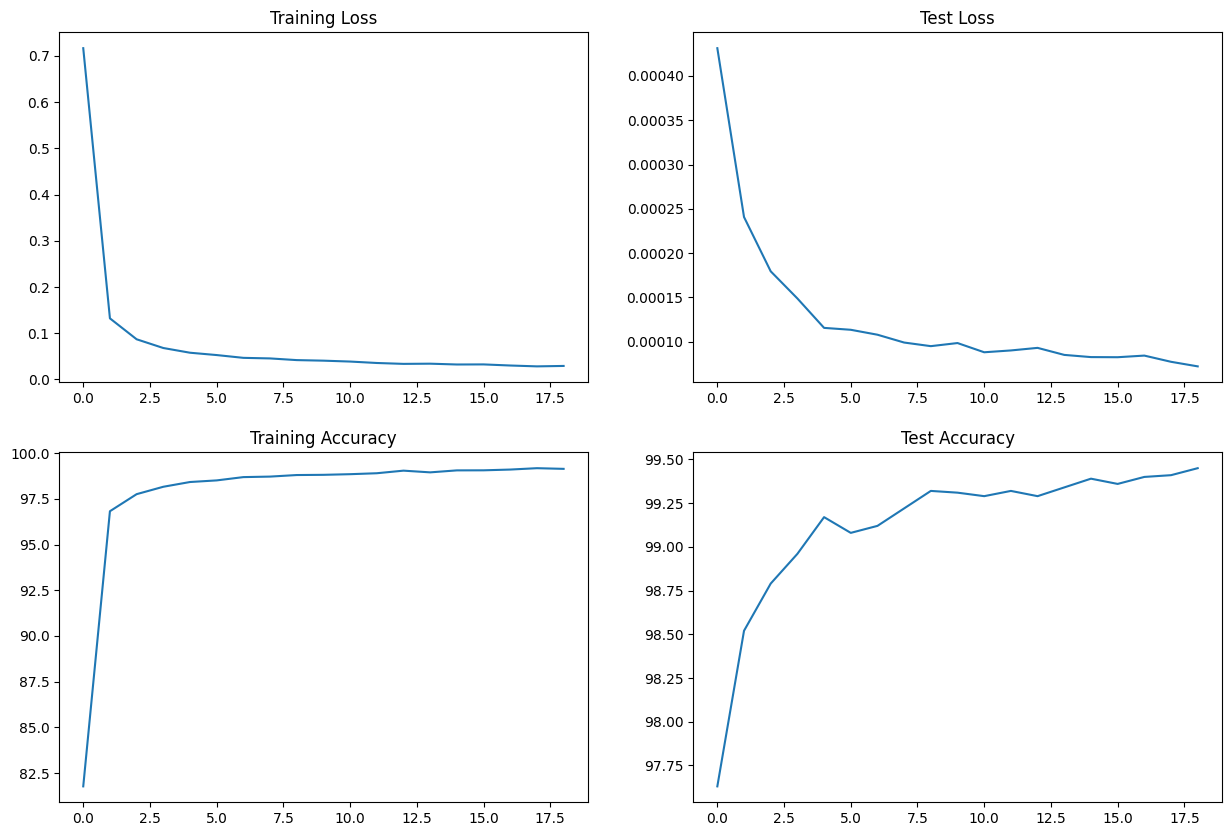

In [8]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")